<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install scikit-learn matplotlib seaborn --quiet

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from google.colab import files
import yfinance as yf


In [26]:
stocklist = ['GFI', 'FSR']
stocks = [i + '.JO' for i in stocklist]
stocks

['GFI.JO', 'FSR.JO']

In [27]:
start = "2013-03-01"
end = "2024-02-28"


df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)

df.head()

/tmp/ipython-input-2495352864.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)
[*********************100%***********************]  2 of 2 completed


Price             Close                      High                       Low  \
Ticker           FSR.JO       GFI.JO       FSR.JO       GFI.JO       FSR.JO   
Date                                                                          
2013-03-01  3121.474121  7431.280273  3132.409222  7503.099358  3062.822219   
2013-03-04  3064.810547  7250.466797  3126.444752  7385.141125  3032.005244   
2013-03-05  3201.001709  7257.449707  3201.001709  7283.386984  3083.697920   
2013-03-06  3107.556396  6928.246094  3220.883789  7299.348692  3105.568197   
2013-03-07  3114.515625  7453.975098  3156.267829  7503.854481  3095.627723   

Price                           Open                 Volume            
Ticker           GFI.JO       FSR.JO       GFI.JO    FSR.JO    GFI.JO  
Date                                                                   
2013-03-01  7338.513956  3084.692420  7465.194841  12379894   5930842  
2013-03-04  7250.466797  3126.444752  7370.177311  14174847   4128626  
2013-03-05  7217.546203  3100.597618  7262.437645  16391688   5666832  
2013-03-06  6928.246094  3202.989990  7258.447599  18189945   6130247  
2013-03-07  7237.498572  3132.409427  7282.390018  18272095  10489933

In [28]:

Close = df['Close']
Close.head()

Ticker,FSR.JO,GFI.JO
Date,,
2013-03-01,3121.474121,7431.280273
2013-03-04,3064.810547,7250.466797
2013-03-05,3201.001709,7257.449707
2013-03-06,3107.556396,6928.246094
2013-03-07,3114.515625,7453.975098


#Confusion matrix, and learning curve (FSR.JO)




✅ Test Accuracy: 58.68%


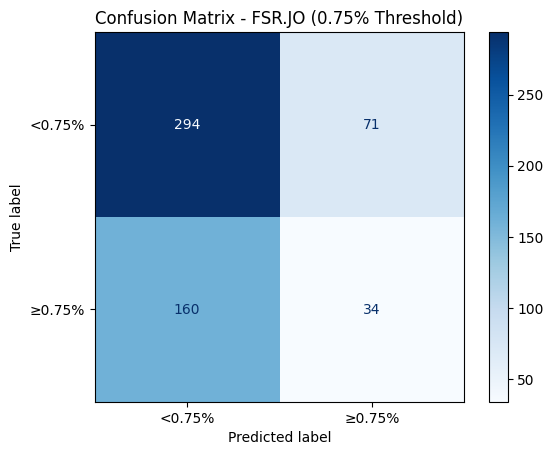

Classification Report:

              precision    recall  f1-score   support

      <0.75%       0.65      0.81      0.72       365
      ≥0.75%       0.32      0.18      0.23       194

    accuracy                           0.59       559
   macro avg       0.49      0.49      0.47       559
weighted avg       0.54      0.59      0.55       559

Accuracy: 0.5868


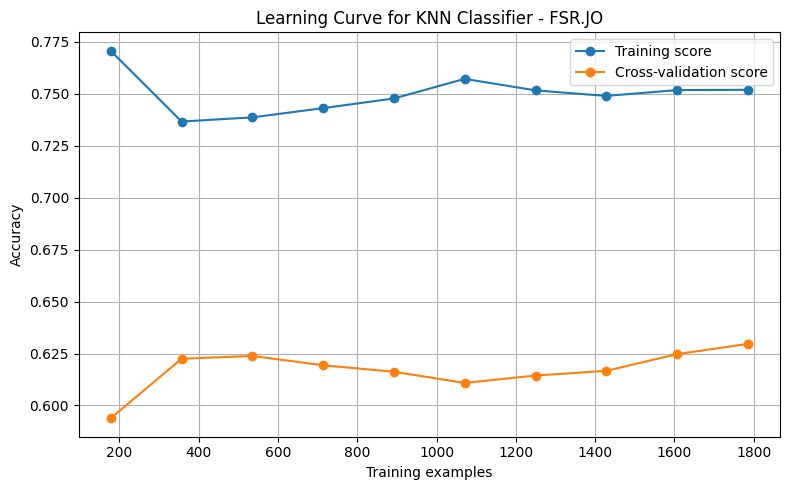

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


Close = df['Close']
fsr = Close['FSR.JO']

returns = fsr.pct_change()
y = (returns >= 0.0075).astype(int)

X = pd.DataFrame()
X['lag_1'] = fsr.shift(1)
X['lag_2'] = fsr.shift(2)
X['ma_3'] = fsr.rolling(3).mean().shift(1)
X['ma_5'] = fsr.rolling(5).mean().shift(1)

# Drop missing values and align target
X = X.dropna()
y = y.loc[X.index]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)


test_accuracy = knn.score(X_test_scaled, y_test)
print(f"✅ Test Accuracy: {test_accuracy:.2%}")

y_pred = knn.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<0.75%", "≥0.75%"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - FSR.JO (0.75% Threshold)")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["<0.75%", "≥0.75%"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_scaled, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for KNN Classifier - FSR.JO')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


#Test if model fit is optimal (FSR.JO)

In [21]:
def evaluate_fit(train_scores_mean, test_scores_mean, threshold_gap=0.05, threshold_low=0.75):
    final_train = train_scores_mean[-1]
    final_val = test_scores_mean[-1]
    gap = final_train - final_val

    print("\n--- Fit Evaluation ---")
    print(f"Final Training Accuracy: {final_train:.4f}")
    print(f"Final Validation Accuracy: {final_val:.4f}")
    print(f"Train-Validation Gap: {gap:.4f}")

    if final_train < threshold_low and final_val < threshold_low:
        print("Model is likely **Underfitting**: Both training and validation accuracy are low.")
    elif gap > threshold_gap:
        print("Model is likely **Overfitting**: Training accuracy is high, but validation accuracy drops.")
    else:
        print("Model is likely a **Good Fit**: Training and validation accuracy are both high and close.")


evaluate_fit(train_scores_mean, test_scores_mean)


--- Fit Evaluation ---
Final Training Accuracy: 0.7520
Final Validation Accuracy: 0.6296
Train-Validation Gap: 0.1223
Model is likely **Overfitting**: Training accuracy is high, but validation accuracy drops.


#Find best value for k (FSR.JO)

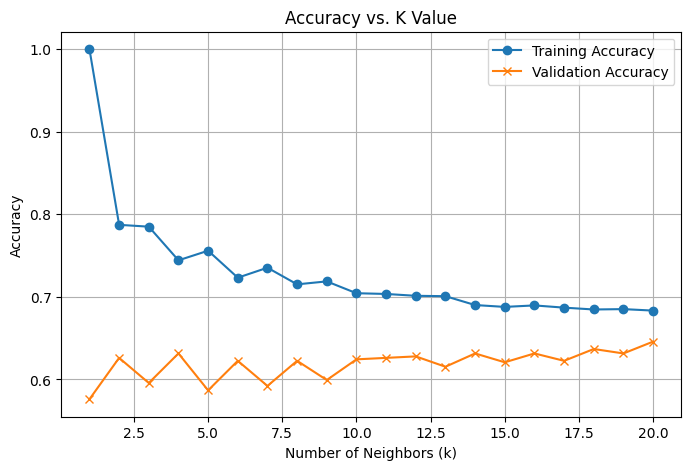

In [22]:
k_range = range(1, 21)
train_acc = []
test_acc = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))


plt.figure(figsize=(8, 5))
plt.plot(k_range, train_acc, label='Training Accuracy', marker='o')
plt.plot(k_range, test_acc, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K Value')
plt.legend()
plt.grid(True)
plt.show()

#Determine ROC curve (FSR.JO)

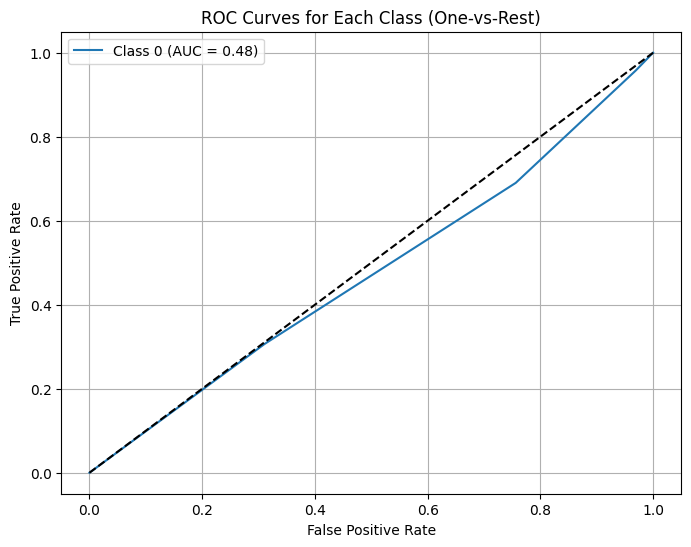

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay


y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.3, random_state=42)
classifier.fit(X_train, y_train_bin)
y_score = classifier.predict_proba(X_test)


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Each Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()